## Fraud Detection: Classification Models
Data set: https://www.kaggle.com/c/ieee-fraud-detection/overview

Predict the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.


### II. Machine Learning Models:

1). Class Imbalance Techniques:
- Random Undersampling
- Syntetic Minority Oversampling Technique (SMOTE)

2). Model Selection and Training:
- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting Classifier

3). Model Evaluation:
- ROC AUC (area under the Receiver Operating Characteristic curve)
- Confusion Matrix/Type I and Type II errors
- f1-score (weighted average of the precision and recall)

4). Hyperparameters Tuning:
- GridSearchCV

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats.mstats import winsorize

import re

from sklearn.utils import resample
from sklearn import tree, ensemble, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Image
import pydotplus
import graphviz

from pprint import pprint

In [2]:
df_train = pd.read_csv('clean_data.csv')

In [3]:
df_train.head()

,Unnamed: 0,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,15,16,17,18,19,20,21,22,23,24
0,0,0,86400,68.5,4,13926,362.555488,150.0,1,142.0,...,-0.022764,-0.014437,0.065160,0.111726,0.033356,0.024903,0.037273,0.024508,-0.022577,-0.034824
1,1,0,86401,29.0,4,2755,404.000000,150.0,2,102.0,...,-0.015561,0.005252,0.010690,0.020556,0.003545,0.009974,0.005884,-0.008021,0.002869,0.002425
2,2,0,86469,59.0,4,4663,490.000000,150.0,4,166.0,...,-0.001823,-0.001482,-0.011709,0.003094,0.010972,0.014120,-0.008092,-0.003880,-0.006475,-0.011768
3,3,0,86499,50.0,4,18132,567.000000,150.0,2,117.0,...,0.112906,-0.056687,-0.062909,0.018963,-0.015766,0.013687,0.011390,0.026251,-0.000547,0.024393
4,4,0,86506,50.0,1,4497,514.000000,150.0,2,102.0,...,-0.010597,-0.003628,0.010857,-0.004550,-0.019525,-0.010890,0.001205,0.017472,-0.012554,0.029350


In [4]:
df_train = df_train.drop(['Unnamed: 0'],axis=1)

### Class Imbalance

To address class imbalance, we'll use Random Undersampling to randomly select samples from the majority class to even it out with the minority class. We'll also train a model after performing SMOTE where we'll synthetically create samples of the minority class.

#### Random Undersampling

In [5]:
# keep original dataframe for smote
df_train_smote = df_train.copy()

In [6]:
y_train=df_train['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=1)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

The number of observations in training set is 472432
The number of observations in test set is 118108


In [7]:
print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 455903, 1: 16529})
Resampled dataset shape Counter({0: 16529, 1: 16529})


### Model Evaluation

For model evaluation, we'll use:
- classification report to see accuracy, precision and F score
- confusion matrix to review false negatives and false positives, and
- roc_auc_score to review true positives and false positives

### Model Selection

## Logistic Regression
Logistic regression with default parameters as a baseline model (Note: we used label encoding on categorical variables, which is ok for tree-based models, but can influence the weight of features for logistic regression).

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.73      0.84    113974
           1       0.08      0.65      0.14      4134

    accuracy                           0.73    118108
   macro avg       0.53      0.69      0.49    118108
weighted avg       0.95      0.73      0.81    118108

-----------------------------------------------
Confusion Matrix:
[[83226 30748]
 [ 1454  2680]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.2603379957327192
Percent Type II errors: 0.012310766417177498
---------------------------------------------
ROC AUC: 0.7571384841851361


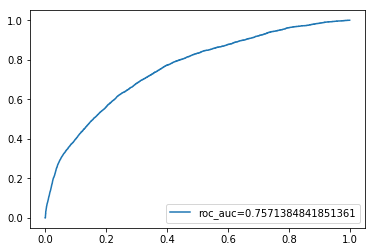

In [8]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, logreg.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

## Decision Tree

In [9]:
features = df_train.drop('isFraud', axis=1).columns

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95    113974
           1       0.17      0.43      0.24      4134

    accuracy                           0.91    118108
   macro avg       0.57      0.68      0.60    118108
weighted avg       0.95      0.91      0.92    118108

-----------------------------------------------
Confusion Matrix:
[[105124   8850]
 [  2344   1790]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.07493141870152742
Percent Type II errors: 0.01984624242218986
---------------------------------------------
ROC AUC: 0.7156588832858263


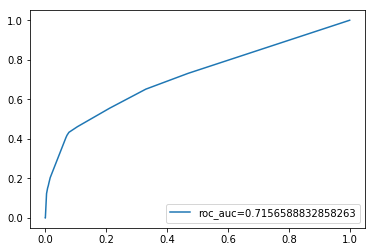

In [10]:
# train decision tree model:
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)
dt = dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, dt.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

We have ROC AUC = 0.715, 2344 false negatives, 8850 false positives.

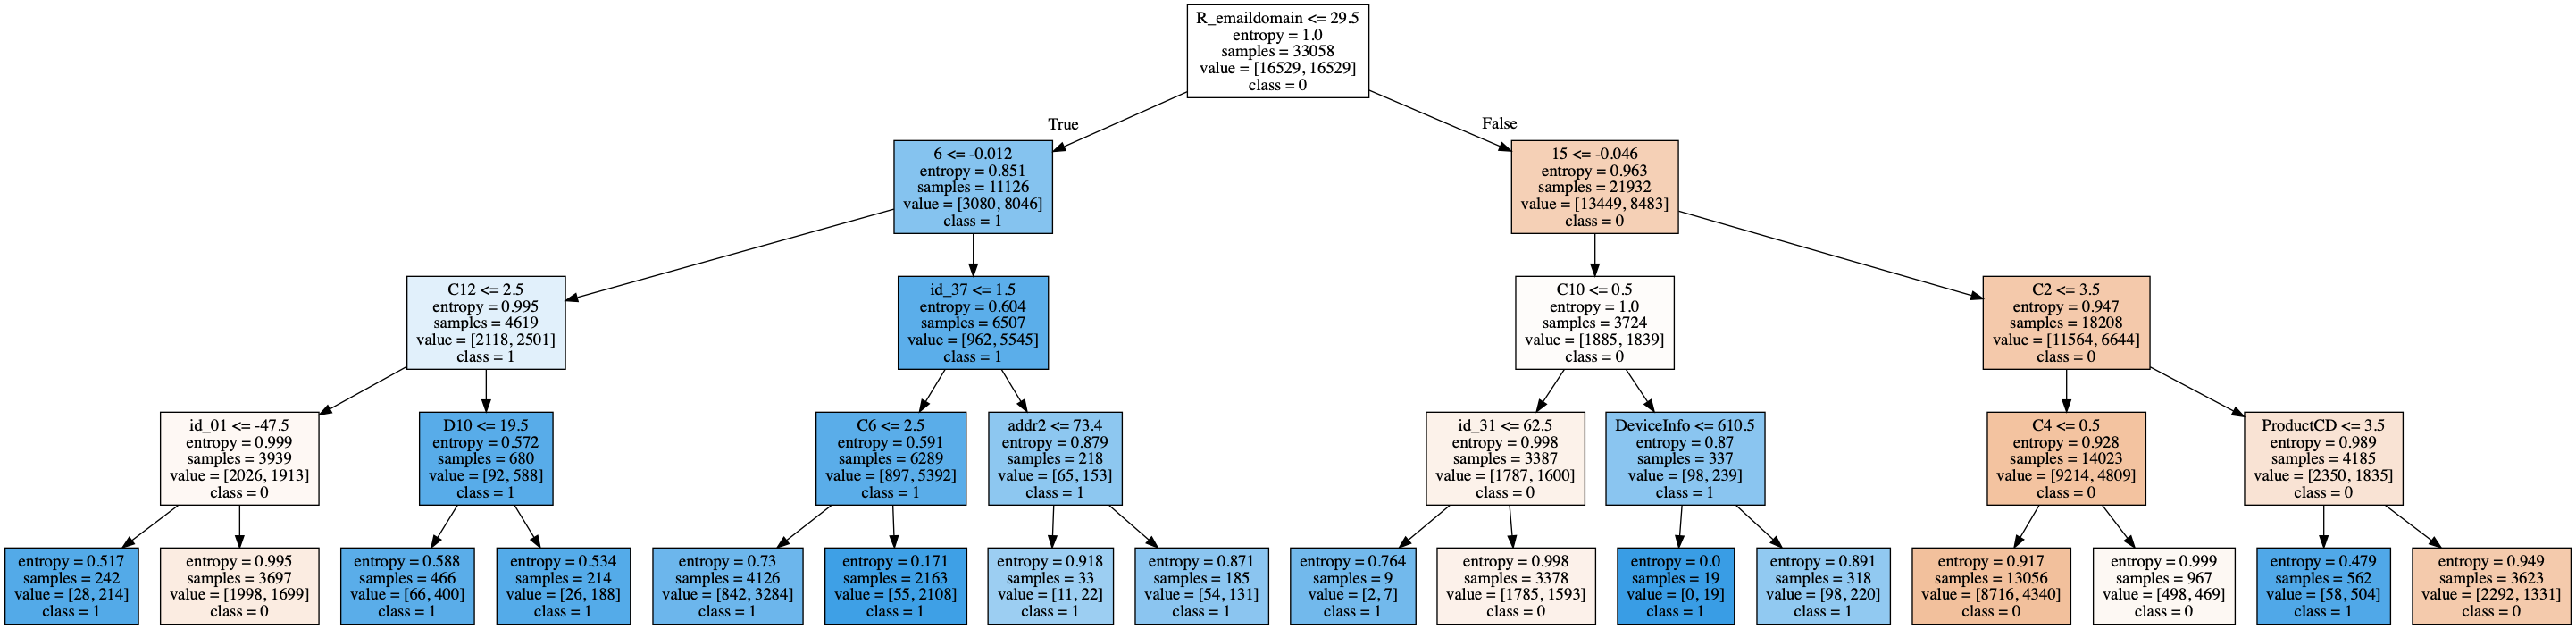

In [11]:
# render the tree:
dot_data = tree.export_graphviz(
    dt, out_file=None,
    feature_names=features,
    class_names=['0', '1'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113974
           1       0.20      0.84      0.33      4134

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Confusion Matrix:
[[100235  13739]
 [   666   3468]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.11632573576726386
Percent Type II errors: 0.005638906763301386
---------------------------------------------
ROC AUC: 0.9316491893953289


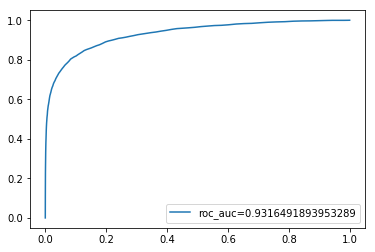

In [12]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfc.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

665 misidentified fraudelent transactions, ROC AUC=0.929

**Feature Importance:**

In [13]:
feature_list = list(df_train.drop('isFraud',axis=1).columns)

importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TransactionAmt       Importance: 0.04
Variable: 1                    Importance: 0.04
Variable: TransactionDT        Importance: 0.03
Variable: card1                Importance: 0.03
Variable: C5                   Importance: 0.03
Variable: C13                  Importance: 0.03
Variable: C14                  Importance: 0.03
Variable: 16                   Importance: 0.03
Variable: card2                Importance: 0.02
Variable: addr1                Importance: 0.02
Variable: C1                   Importance: 0.02
Variable: C8                   Importance: 0.02
Variable: C10                  Importance: 0.02
Variable: D2                   Importance: 0.02
Variable: D3                   Importance: 0.02
Variable: 3                    Importance: 0.02
Variable: 6                    Importance: 0.02
Variable: 8                    Importance: 0.02
Variable: 10                   Importance: 0.02
Variable: ProductCD            Importance: 0.01
Variable: card3                Importanc

**Retrain the Random Forest model with less features:**

In [14]:
df_train2 = df_train.drop(['C3','C7','M1','M2', 'M3','M6',
                                        'M7','M9','M8','id_01','id_05',
                                       'id_06','id_11','id_12','id_13',
                                       'id_15','id_16','id_28','id_29',
                                       'id_37','id_38','DeviceType','DeviceInfo'],
                                       axis=1)

In [15]:
# retrain the model with less features:
y_train=df_train2['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train2.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=1)
# undersample:
print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

Original dataset shape Counter({0: 455903, 1: 16529})
Resampled dataset shape Counter({0: 16529, 1: 16529})


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113974
           1       0.20      0.84      0.32      4134

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Confusion Matrix:
[[100045  13929]
 [   666   3468]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.11793443289192942
Percent Type II errors: 0.005638906763301386
---------------------------------------------
ROC AUC: 0.9299563311653871


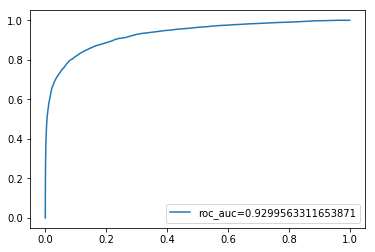

In [16]:
rfc2 = RandomForestClassifier(n_estimators=100)
rfc2.fit(X_train, y_train)
y_pred = rfc2.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfc2.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfc2.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

ROC AUC=0.931; there are 669 misidentified fraudelent transactions. 13,792 false positives 

**Retrain the model with 300 decision trees:**

In [17]:
# split and undersample majority in original data:
y_train=df_train['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=1)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

# undersample:
print('Original dataset shape %s' % Counter(y_train))

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

The number of observations in training set is 472432
The number of observations in test set is 118108
Original dataset shape Counter({0: 455903, 1: 16529})
Resampled dataset shape Counter({0: 16529, 1: 16529})


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113974
           1       0.20      0.84      0.33      4134

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Confusion Matrix:
[[100345  13629]
 [   647   3487]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.11539438480035222
Percent Type II errors: 0.005478037050834829
---------------------------------------------
ROC AUC: 0.9331434307889961


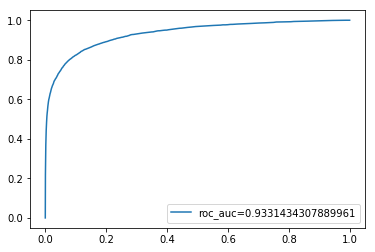

In [18]:
rfc3 = RandomForestClassifier(n_estimators=300)

rfc3.fit(X_train, y_train)
y_pred = rfc3.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfc3.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfc3.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

ROC AUC=0.9314; 647 false negatives.

## Hyperparameters Tuning
We'll tune the hyperparameters of our Random Forest model trained on randomly undersampled data and with less features.

In [19]:
# review hyperparameters of the model:
pprint(rfc3.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


We'll tune:

- n_estimators -- the number of trees in the foreset
- max_features -- the number of features to consider when looking for the best split
- max_depth  -- max number of levels in each decision tree
- criterion -- gini or entropy to measure the quality of a split

**Grid Search with cross validation:**

In [20]:
# create parameter grid:
param_grid = {
    'max_depth': [None, 80, 100],
    'max_features': ['auto', 2],
    'n_estimators': [100, 300, 1000],
    'criterion':['gini','entropy']
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [21]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 20.9min finished


{'criterion': 'entropy',
 'max_depth': 100,
 'max_features': 'auto',
 'n_estimators': 1000}

**Run the Random Forest model with best parameters:**

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    113974
           1       0.20      0.84      0.33      4134

    accuracy                           0.88    118108
   macro avg       0.60      0.86      0.63    118108
weighted avg       0.97      0.88      0.91    118108

-----------------------------------------------
Confusion Matrix:
[[100423  13551]
 [   657   3477]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.11473397229654214
Percent Type II errors: 0.005562705320554069
---------------------------------------------
ROC AUC: 0.9344858836026302


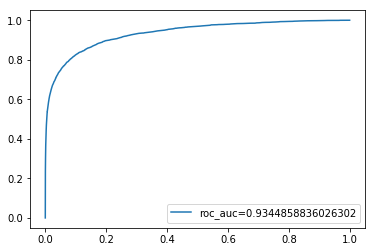

In [22]:
rfc4 = RandomForestClassifier(criterion='entropy',
                             max_depth=100,
                             max_features='auto',
                             n_estimators=1000)

rfc4.fit(X_train, y_train)
y_pred = rfc4.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfc4.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfc4.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

## Gradient Boosting Classifier

Let's try another ensemble model -- gradient boosting model, which uses boosting instead of bagging when learning from data.

In [23]:
gbc = ensemble.GradientBoostingClassifier(n_estimators=100,
                                          max_depth=2,
                                          loss='deviance')
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [24]:
y_pred = gbc.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    113974
           1       0.14      0.77      0.24      4134

    accuracy                           0.83    118108
   macro avg       0.56      0.80      0.57    118108
weighted avg       0.96      0.83      0.88    118108

-----------------------------------------------
Confusion Matrix:
[[94246 19728]
 [  940  3194]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.1670335625021167
Percent Type II errors: 0.00795881735360856
---------------------------------------------
ROC AUC: 0.8766009877026673


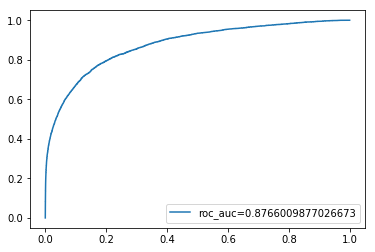

In [25]:
print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, gbc.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = gbc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

### SMOTE
Let's perform SMOTE and train a random forest model with 100 trees.

In [26]:
# split and undersample majority in original data:
y_train=df_train_smote['isFraud']
X_train,X_test,y_train,y_test=train_test_split(df_train_smote.drop('isFraud',axis=1),
                                               y_train,
                                               test_size=.2,
                                               random_state=1)

print('The number of observations in training set is {}'.format(X_train.shape[0]))
print('The number of observations in test set is {}'.format(X_test.shape[0]))

print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(ratio='minority',random_state=42)
X_train, y_train = sm.fit_sample(X_train, y_train)

print('Resampled dataset shape %s' % Counter(y_train))

The number of observations in training set is 472432
The number of observations in test set is 118108
Original dataset shape Counter({0: 455903, 1: 16529})
Resampled dataset shape Counter({0: 455903, 1: 455903})


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113974
           1       0.91      0.56      0.70      4134

    accuracy                           0.98    118108
   macro avg       0.94      0.78      0.84    118108
weighted avg       0.98      0.98      0.98    118108

-----------------------------------------------
Confusion Matrix:
[[113729    245]
 [  1800   2334]]
----------------------------------------------
Test set accuracy:
Percent Type I errors: 0.0020743726081213806
Percent Type II errors: 0.015240288549463204
---------------------------------------------
ROC AUC: 0.9329136839015788


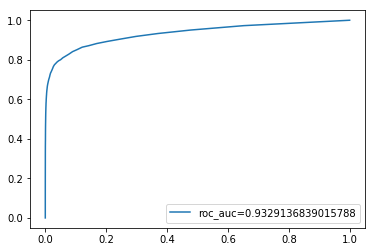

In [27]:
rfcs = RandomForestClassifier(n_estimators=100)
rfcs.fit(X_train, y_train)
y_pred = rfcs.predict(X_test)

print('Classification Report:')
print(metrics.classification_report(y_test, y_pred))

print('-----------------------------------------------')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test, y_pred))

table_test = pd.crosstab(y_test, rfcs.predict(X_test), margins=True)
test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print('----------------------------------------------')
print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(test_tI_errors, test_tII_errors))

print('---------------------------------------------')
# ROC curve
y_pred_proba = rfcs.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
print('ROC AUC:',auc)
plt.plot(fpr,tpr,label='roc_auc='+str(auc))
plt.legend(loc=4)
plt.show()

## Summary
    Model:         ROC_AUC FN   (TypeII) FP    (TypeI)
    Logistic Reg:  0.7571  1454 (0.012)  30748 (0.260)
    Decision Tree: 0.7156  2344 (0.019)  8850  (0.074)
    RF(n_est=100): 0.9316  666  (0.005)  13739 (0.116)
    RF(<features): 0.9299  666  (0.005)  13929 (0.117)
    RF(n_est=300): 0.9331  647  (0.005)  13629 (0.115)
    RF(best param):0.9344  657  (0.005)  13551 (0.114) 
    GradientBoost: 0.8766  940  (0.007)  19728 (0.167)
    RF_SMOTE:      0.9329  1800 (0.015)  245   (0.002)